# Using MSE and qv budgets to diagnose ITCZ changes

In [21]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# from ipywidgets import IntProgress
from IPython.display import display
# %matplotlib inline
plt.rcParams.update({'font.size': 14})#increase font size

from functions_mpas import compute_mse_budget

In [22]:
pth='/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/'
list_of_exps = ['minus4K','CTL','plus4K'] #'minus4K'
expLabels = {
    'CTL': 'CTL',
    'plus4K' : 'plus4K',
    'minus4K':'minus4K',
    '30km' : '30 km',
    '15km' : '15 km',
    'TC_3km' : '3 km',
    'CTL/120km' : 'CTL (120 km)',
    'HOMO_RAD/120km' : 'HOMO_RAD (120 km)',
    'HOMO_RAD/120km_from_restart' : 'HOMO_RAD_rst',
    'HOMO_RAD/120km_online': 'HOMO_RAD_online'
}
nexps = len(list_of_exps)

lineColors = {
    'minus4K':'tab:blue',
    'CTL':'gray',
    'plus4K':'red',
    'CTL/120km':'black',
    'HOMO_RAD' : 'purple',
    'HOMO_RAD/120km':'red',
    'HOMO_RAD/120km_online':'tab:orange',
    'HOMO_RAD/120km_from_restart' : 'tab:blue'}

#define constants
Rearth = 6379.0e3
G = 9.81
Cp = 1004.1
Lv = 2.5e6
Rd = 287.15

In [23]:
import os

def get_itcz_HC_metrics(expName,metricNames):
    " Reads lat-lon MPAS fields and calculates metrics of the ITCZ and Hadley cell."
    out = {}

    for metric in metricNames:
        if (metric == 'maxpr') | (metric=='maxpr_loc') | (metric=='pcent'):
            fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
            ds = xr.open_dataset(fname2d)
            pr = ds.pr.sel(lat=slice(-15,15)).mean('time').mean('lon')
            if (metric == 'maxpr'):
                out[metric] = pr.max()
            elif (metric=='maxpr_loc'):
                out[metric] = pr.idxmax()
            elif (metric=='pcent'):
                out[metric] = (pr*pr.lat).sum()/(pr.sum())
        elif (metric == 'itcz_strength_streamFunction') | (metric == 'itcz_width_streamFunction') |\
             (metric == 'itcz_loc_streamFunction') | (metric == 'itcz_area_streamFunction') | \
             (metric == 'itcz_boundaries_streamFunction') | (metric == 'HC_boundaries'):
            # check if we've saved the streamfunction already
            fOut = pth+expName+'/TC_3km/latlon/streamFunction.nc'
            if os.path.exists(fOut):
              streamFunction_vavg = xr.open_dataset(fOut)['streamFunction']
            else:
                # calculate streamfunction
                fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
                vaModel  = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).uReconstructMeridional.squeeze().mean('lon')
                zModel = vaModel.level
                plev  = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).pressure.squeeze().mean('lon')
                # interpolate to isobaric surfaces
                p_int = np.linspace(50.0e2,1000.0e2, 37)
                va_isobaric = xr.DataArray(np.zeros((len(vaModel.lat),len(p_int))),\
                                           coords=[vaModel.lat,p_int],\
                                           dims=('lat','pressure'))
                for k in range(len(vaModel.lat)):
                    p_old = plev[k,::-1]
                    va_isobaric[k,:] = np.interp(p_int,p_old,vaModel[k,::-1])
    
                streamFunction = xr.DataArray(np.zeros((len(vaModel.lat),len(p_int))),\
                                           coords=[vaModel.lat,p_int],\
                                           dims=('lat','pressure'),name='streamFunction')
                streamFunction[:,:] = 0.0
                mfac = (2.0*np.pi*Rearth*np.cos(np.radians(va_isobaric.lat))/G)
                for k in np.arange(1,len(p_int)):
                    streamFunction[:,k] = mfac*np.trapz(va_isobaric[:,0:k],p_int[0:k],axis=1)
                # averaging only between select pressure levels
                streamFunction_vavg = streamFunction.sel(pressure=slice(300e2, 700e2)).mean('pressure')
                # save to a netcdf file for future use
                streamFunction_vavg.to_netcdf(fOut)
            # now that we have calculated or read the streamfunction, let's get the metrics
            if (metric == 'itcz_strength_streamFunction'):
                area = 2.0*np.pi*(Rearth)**2.0*(np.sin(np.radians(streamFunction_vavg.idxmax()))-\
                                                       np.sin(np.radians(streamFunction_vavg.idxmin())))
                mass_transport=streamFunction_vavg.sel(lat=streamFunction_vavg.idxmax())-streamFunction_vavg.sel(lat=streamFunction_vavg.idxmin())
                out[metric]=(-G*mass_transport/area)
            # elif (metric == 'HC_descent_strength'):
                
            elif (metric == 'itcz_width_streamFunction'):
                out[metric] = (streamFunction_vavg.idxmax())-(streamFunction_vavg.idxmin())
            elif (metric == 'itcz_boundaries_streamFunction'):
                out['itcz_minLat'] = streamFunction_vavg.idxmin()
                out['itcz_maxLat'] = streamFunction_vavg.idxmax()
            elif (metric == 'itcz_loc_streamFunction'):
                temp=streamFunction_vavg.sel(lat=slice(-15,15))
                out[metric] = np.interp([0.0], temp, temp.lat) 
            elif (metric == 'itcz_area_streamFunction'):
                out[metric] = 2.0*np.pi*(Rearth)**2.0*(np.sin(np.radians(streamFunction_vavg.idxmax()))-\
                                                       np.sin(np.radians(streamFunction_vavg.idxmin())))
            elif (metric == 'HC_boundaries'):
                # subset to find the zero crossing in the SH
                temp = streamFunction_vavg.sel(lat=slice(-30,-15))
                # values must be increasing for np.interp
                out['HC_minLat'] = np.interp(0.0,temp[::-1],temp.lat[::-1])
                # subset to find the zero crossing in the NH
                temp = streamFunction_vavg.sel(lat=slice(25,40))
                # values must be increasing for np.interp
                out['HC_maxLat'] = np.interp(0.0,temp[::-1],temp.lat[::-1])
        elif (metric == 'energyFluxEquator') | (metric == 'energyFlux_at_Equator'):
            ncfile = '/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/%s/TC_3km/latlon/radFluxes_r360x180.nc'%expName
            ds = xr.open_dataset(ncfile)
            E, H, znetclr_atm, znetcf_atm, netsw, netlw, znet_atm = compute_mse_budget(ds)
            total = E+H+znet_atm
            print(total.max())
            # remove the global mean
            weightForAvg = np.cos(np.radians(total.lat))
            globalAvg = (weightForAvg*total).sum()/(weightForAvg.sum())
            print(globalAvg)
            total = total-globalAvg
            # create new array
            transport_array = np.zeros(len(total))
            # weight
            dlat = np.radians(ds.lat[1]-ds.lat[0])
            dlon = np.radians(ds.lon[1]-ds.lon[0])
            weightForTransport = np.cos(np.radians(ds.lat))*Rearth*Rearth*dlat*dlon*len(ds.lon) #because we took the average along longitude
            # transport is the cumulative sum from the south pole until that latitude
            total = total*weightForTransport
            transport_array[1:] = total.cumsum()[0:-1]  # Improved vectorization
            transport = xr.DataArray(transport_array, dims=total.dims, coords=total.coords)

            if (metric == 'energyFluxEquator'):
                # negvals = np.where(transport < 0)[0]
                # posvals = np.where(transport >= 0)[0]
                # out[metric]=0.5*(transport.lat[negvals[-1]].values+transport.lat[posvals[0]].values)
                fig = plt.figure()
                plt.plot(transport.lat, transport)
                display(fig)
                out[metric] = np.interp(0.0, transport.sel(lat=slice(-25,25)), transport.lat.sel(lat=slice(-25,25)))
            elif (metric == 'energyFlux_at_Equator'):
                out[metric] = np.interp([0.0], transport.lat, transport) #.sel(lat=0,method='nearest') #np.interp(temp.lat, [0.0], temp)
        elif (metric == 'wa100-300') | (metric == 'wa100-300_loc'):
            fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180.nc'
            waModel  = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).w.squeeze().mean('lon')
            # scale to cm per s
            waModel = waModel*100.0
            plev = xr.open_dataset(fname3d).sel(lat=slice(-90,90)).pressure.squeeze().mean('lon')
            # interpolate to 500 mb
            p_int = np.linspace(50.0e2,1000.0e2, 37)
            wa_isobaric = xr.DataArray(np.zeros((len(waModel.lat),len(p_int))),\
                                       coords=[waModel.lat,p_int],dims=('lat','pressure'))
            for k in range(len(wa_isobaric.lat)):
                p_old = plev[k,::-1]
                wa_isobaric[k,:] = np.interp(p_int,p_old,waModel[k,::-1])
            if (metric == 'wa500'):
                out[metric] = wa_isobaric.sel(pressure=500e2).max()
            elif (metric == 'wa500_loc'):
                out[metric] = wa_isobaric.sel(pressure=500e2).idxmax()
            elif (metric == 'wa100-300'):
                out[metric] = wa_isobaric.sel(pressure=slice(100e2,300e2)).mean('pressure').max()
            elif (metric == 'wa100-300_loc'):
                out[metric] = wa_isobaric.sel(pressure=slice(100e2,300e2)).mean('pressure').idxmax()

    return out

### Calculating ITCZ width metrics following [Byrne and Schneider (2006)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016GL070396)

Get ITCZ and Hadley Cell metrics

In [8]:
metricNames = ['itcz_boundaries_streamFunction', 'itcz_strength_streamFunction', 'HC_boundaries']
list_of_exps=['minus4K','CTL','plus4K']
metrics_per_exp = {}
for expName in list_of_exps:
    metrics = get_itcz_HC_metrics(expName,metricNames)
    # Calculate ITCZ area, Hadley cell area, and the descent area
    metrics['itcz_area'] = 2.0*np.pi*(Rearth)**2.0*(np.sin(np.radians(metrics['itcz_maxLat']))-np.sin(np.radians(metrics['itcz_minLat']))).values
    metrics['HC_area'] = 2.0*np.pi*(Rearth)**2.0*(np.sin(np.radians(metrics['HC_maxLat']))-np.sin(np.radians(metrics['HC_minLat'])))
    metrics['d_area'] = metrics['HC_area']-metrics['itcz_area']
    # Calculate "strength" or omega within the descent area
    metrics['HC_descent_strength'] = -(metrics['itcz_area']/metrics['d_area'])*\
                                        metrics['itcz_strength_streamFunction']
    print(metrics)
    metrics_per_exp[expName] = metrics

{'itcz_minLat': <xarray.DataArray 'lat' ()> Size: 8B
array(-2.5), 'itcz_maxLat': <xarray.DataArray 'lat' ()> Size: 8B
array(16.5), 'itcz_strength_streamFunction': <xarray.DataArray ()> Size: 8B
array(-0.04284319), 'HC_minLat': -24.31639105999375, 'HC_maxLat': 34.33895282988499, 'itcz_area': 83767394449040.94, 'HC_area': 249501841578860.88, 'd_area': 165734447129819.94, 'HC_descent_strength': <xarray.DataArray ()> Size: 8B
array(0.02165429)}
{'itcz_minLat': <xarray.DataArray 'lat' ()> Size: 8B
array(-1.5), 'itcz_maxLat': <xarray.DataArray 'lat' ()> Size: 8B
array(15.5), 'itcz_strength_streamFunction': <xarray.DataArray ()> Size: 8B
array(-0.04530755), 'HC_minLat': -25.424839233323585, 'HC_maxLat': 34.54924369246135, 'itcz_area': 75018411692843.89, 'HC_area': 254763192411130.62, 'd_area': 179744780718286.75, 'HC_descent_strength': <xarray.DataArray ()> Size: 8B
array(0.01890959)}
{'itcz_minLat': <xarray.DataArray 'lat' ()> Size: 8B
array(-0.5), 'itcz_maxLat': <xarray.DataArray 'lat' ()> 

Calculate changes in ascent and descent area

In [9]:
def changes(a,b):
    return (b-a)/a

In [10]:
# changes from minus4K -> CTL
changeI = changes(metrics_per_exp['minus4K']['itcz_area'],
                  metrics_per_exp['CTL']['itcz_area'])
changeD = changes(metrics_per_exp['minus4K']['d_area'],
                  metrics_per_exp['CTL']['d_area'])
print(changeI, changeD, changeI-changeD)

-0.10444377330513012 0.08453483166050874 -0.18897860496563884


In [11]:
# changes from CTL -> plus4K
changeI = changes(metrics_per_exp['CTL']['itcz_area'],
                  metrics_per_exp['plus4K']['itcz_area'])
changeD = changes(metrics_per_exp['CTL']['d_area'],
                  metrics_per_exp['plus4K']['d_area'])
print(changeI, changeD, changeI-changeD)

-0.17464467862767488 0.17433625945512704 -0.34898093808280195


Read climatological values to get the divergent component of the MSE budget, GMS, etc.

In [12]:
def get_itcz_width_changes_mechanisms(expName):
    print(expName)
    # read in time mean, zonal mean model fields
    fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
    ds = xr.open_dataset(fname3d)#.sel(level=slice(0,18.0e3))
    mse = (Cp*ds.temperature+Lv*ds.qv+G*ds.level).mean('lon')
    va = ds.uReconstructMeridional.mean('lon')
    rhod = (ds.pressure/(Rd*ds.temperature)).mean('lon')
    dz = np.gradient(ds.level)
    coslat = np.cos(np.radians(ds.lat))
    del ds

    # calculate mean advective component
    dmse_y = np.gradient(mse,np.radians(mse.lat)*Rearth,axis=0)
    mse_adv = va*dmse_y
    meanAdv = xr.DataArray(np.trapz(mse_adv*rhod,mse.level,axis=-1),coords=[mse.lat])
    # weigh by cosine of latitude
    meanAdv = meanAdv * coslat
    meanAdv_i = (meanAdv.sel(lat=slice(metrics_per_exp[expName]['itcz_minLat'],
                          metrics_per_exp[expName]['itcz_maxLat'])).mean())
    
    # get GMS 
    # first we need the divergent component
    div_y = np.gradient(va,np.radians(va.lat)*Rearth,axis=0)
    mse_div = mse*(div_y)
    H = xr.DataArray(np.trapz(mse_div*rhod,mse.level,axis=-1),coords=[mse.lat])
    # weigh by cosine of latitude
    H = H * coslat
    H_i = H.sel(lat=slice(metrics_per_exp[expName]['itcz_minLat'],
                          metrics_per_exp[expName]['itcz_maxLat'])).mean()

    gms_i = -H_i/metrics_per_exp[expName]['itcz_strength_streamFunction']

    # # get eddy terms
    # fname3d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
    # ds = xr.open_dataset(fname3d)
    # mse = (Cp*ds.temperature+Lv*ds.qv+G*ds.level)
    # va = ds.uReconstructMeridional
    # rhod = (ds.pressure/(Rd*ds.temperature)).mean('lon').mean('time')
    # dz = np.gradient(ds.level)
    # coslat = np.cos(np.radians(ds.lat))
    # del ds
    
    # fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
    # ds = xr.open_dataset(fname3d)
    # mseClimo = (Cp*ds.temperature+Lv*ds.qv+G*ds.level)
    # vaClimo = ds.uReconstructMeridional
    # del ds
    
    # # subtract the time mean
    # mse = (mse-mseClimo)
    # va = (va-vaClimo)
    
    # mseFluxEddy_y = (mse*va).mean('time').mean('lon')
    # mseFluxEddy_y_vint = np.trapz(mseFluxEddy_y*rhod,mse.level,axis=1)
    # mseFluxEddy_vint_div = np.gradient(mseFluxEddy_y_vint,np.radians(mse.lat)*Rearth,axis=0)
    # transEddies = xr.DataArray(mseFluxEddy_vint_div,coords=[mse.lat])
    # transEddies = transEddies * coslat

    # now we transition to the energy forcing
    ncfile = '/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/%s/TC_3km/latlon/radFluxes_r360x180.nc'%expName
    ds = xr.open_dataset(ncfile)
    E, SH, znetclr_atm, znetcf_atm, netsw, netlw, znet_atm = compute_mse_budget(ds)
    total = E+SH+znet_atm
    # weigh by cosine of latitude
    total = total * coslat

    # energy budget within the ITCZ
    energyBudget_i = total.sel(lat=slice(metrics_per_exp[expName]['itcz_minLat'],
                                         metrics_per_exp[expName]['itcz_maxLat'])).mean()

    # calculate eddies as the residual from the energy budget [for now]
    transEddies = total - H - meanAdv
    TE_i = transEddies.sel(lat=slice(metrics_per_exp[expName]['itcz_minLat'],
                          metrics_per_exp[expName]['itcz_maxLat'])).mean()

    plt.figure(figsize=(10,5))
    plt.plot(ds.lat,H)
    plt.plot(ds.lat,meanAdv)
    plt.plot(ds.lat,total)
    plt.plot(ds.lat,transEddies)
    plt.axhline(y=0,color='gray',linestyle='dashed')
    plt.legend(['div','adv','energy input','eddies'])

    # for the changes in the descent area, we neglect everything within the ITCZ
    meanAdv = meanAdv.where( (meanAdv.lat<metrics_per_exp[expName]['itcz_minLat']) |\
                             (meanAdv.lat>metrics_per_exp[expName]['itcz_maxLat']))
    H = H.where( (H.lat<metrics_per_exp[expName]['itcz_minLat']) |\
                             (H.lat>metrics_per_exp[expName]['itcz_maxLat']))
    total = total.where( (total.lat<metrics_per_exp[expName]['itcz_minLat']) |\
                             (total.lat>metrics_per_exp[expName]['itcz_maxLat']))
    transEddies = transEddies.where( (transEddies.lat<metrics_per_exp[expName]['itcz_minLat']) |\
                             (transEddies.lat>metrics_per_exp[expName]['itcz_maxLat']))
    # then we average within the HC boundaries
    meanAdv_d = meanAdv.sel(lat=slice(metrics_per_exp[expName]['HC_minLat'],
                                      metrics_per_exp[expName]['HC_maxLat'])).mean()
    H_d = H.sel(lat=slice(metrics_per_exp[expName]['HC_minLat'],
                          metrics_per_exp[expName]['HC_maxLat'])).mean()
    print(H.sel(lat=slice(metrics_per_exp[expName]['HC_minLat'],
                          metrics_per_exp[expName]['HC_maxLat'])))
    gms_d = -H_d/metrics_per_exp[expName]['HC_descent_strength']
    energyBudget_d = total.sel(lat=slice(metrics_per_exp[expName]['HC_minLat'],
                                         metrics_per_exp[expName]['HC_maxLat'])).mean()
    TE_d = transEddies.sel(lat=slice(metrics_per_exp[expName]['HC_minLat'],
                          metrics_per_exp[expName]['HC_maxLat'])).mean()
    
    out = {
        'meanAdv_i': meanAdv_i,
        'gms_i': gms_i,
        'H_i': H_i,
        'meanAdv_d': meanAdv_d,
        'H_d': H_d,
        'gms_d': gms_d,
        'energyBudget_i': energyBudget_i,
        'energyBudget_d': energyBudget_d,
        'TE_i': TE_i,
        'TE_d': TE_d,
    }
    # voila
    return out

minus4K
<xarray.DataArray (lat: 58)> Size: 464B
array([10.85921758,  9.04922211,  7.22535512,  6.27935879,  6.71669639,
        6.31651776,  7.35587587,  9.20582928, 11.53582574, 13.46382202,
       15.49150377, 18.57458236, 22.18154353, 26.4618612 , 30.38247558,
       33.66079257, 36.11775038, 36.81782118, 35.18189254, 32.62523629,
       30.71658713,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan, 13.52490087, 16.88440917, 19.30632393, 21.53801134,
       23.40237416, 25.23854356, 26.7493883 , 28.25923459, 30.12370812,
       31.62692927, 32.93647946, 34.74691414, 37.16254541, 38.97365586,
       39.52122989, 40.03249525, 39.98085589])
Coordinates:
  * lat      (lat) float64 464B -23.5 -22.5 -21.5 -20.5 ... 30.5 31.5 32.5 33.5
{'meanAdv_i': <xarra

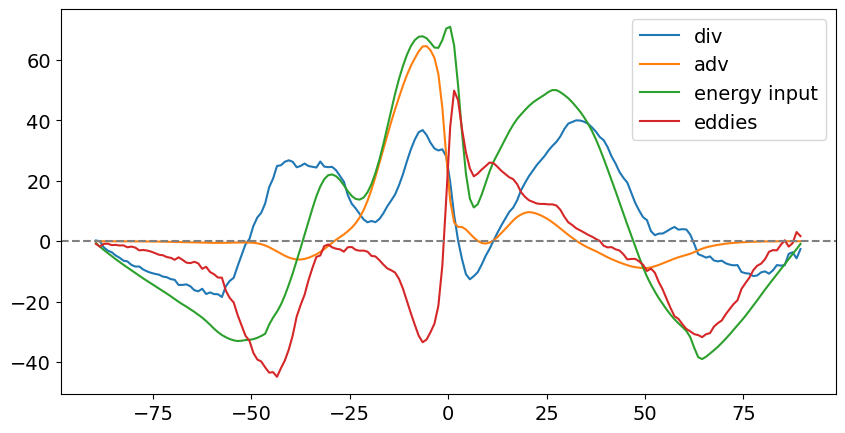

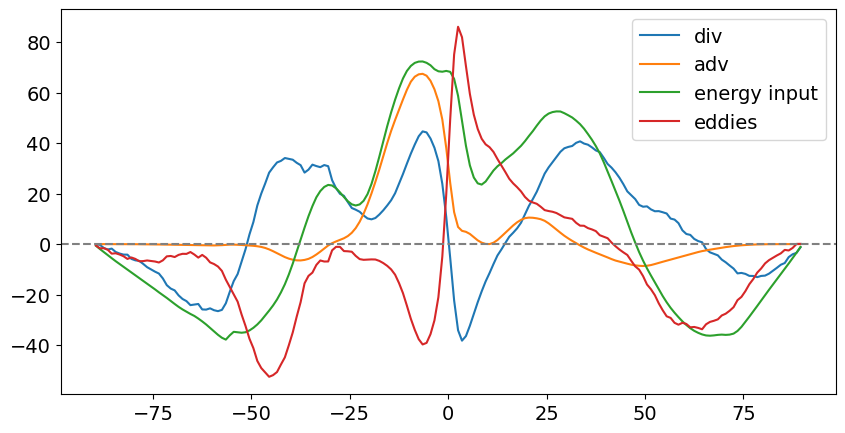

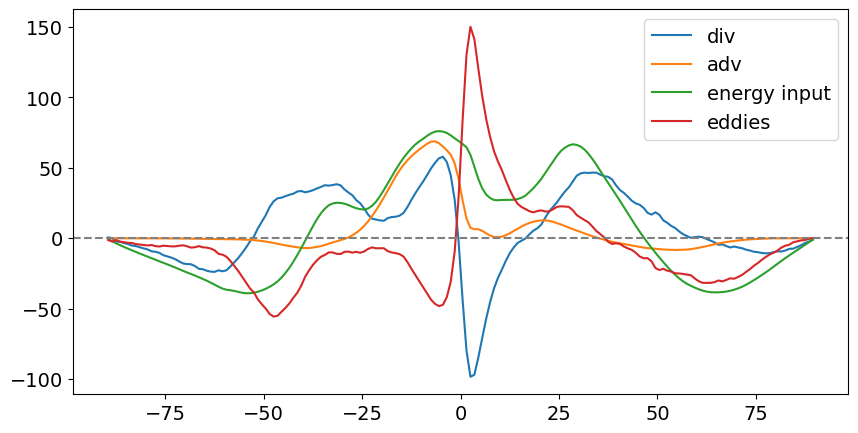

In [13]:
physics_per_exp = {}
for expName in list_of_exps:
    physics = get_itcz_width_changes_mechanisms(expName)
    print(physics)
    physics_per_exp[expName] = physics

Plot everything

0.17433625945512704
<xarray.DataArray ()> Size: 8B
array(2.04265904) <xarray.DataArray ()> Size: 8B
array(0.37033638)


<BarContainer object of 6 artists>

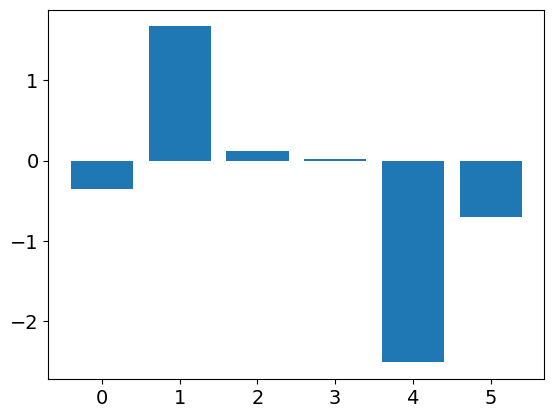

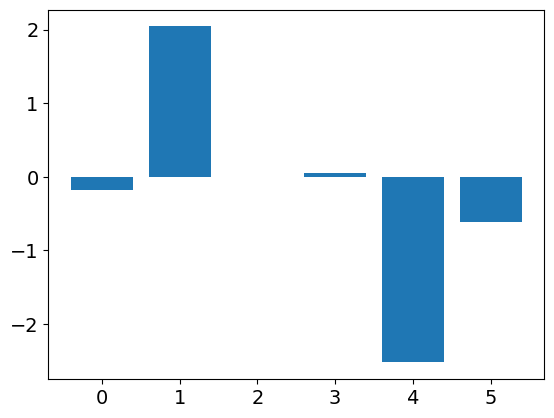

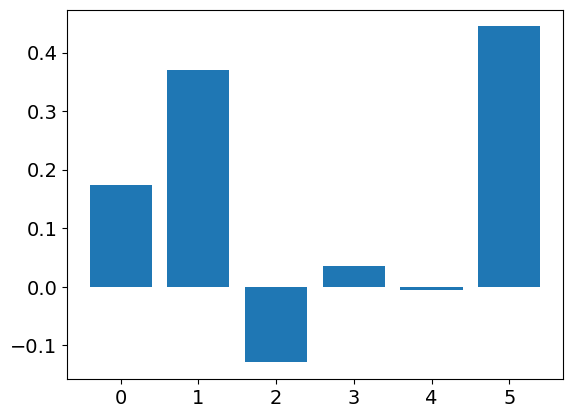

In [20]:
change_i = changes(metrics_per_exp['CTL']['itcz_area'],
                  metrics_per_exp['plus4K']['itcz_area'])
change_d = changes(metrics_per_exp['CTL']['d_area'],
                  metrics_per_exp['plus4K']['d_area'])
print(change_d)
change_GMS_i = changes(physics_per_exp['CTL']['gms_i'],
                  physics_per_exp['plus4K']['gms_i'])
change_GMS_d = changes(physics_per_exp['CTL']['gms_d'],
                  physics_per_exp['plus4K']['gms_d'])
print(change_GMS_i,change_GMS_d)
change_EB_i = (physics_per_exp['plus4K']['energyBudget_i']-\
               physics_per_exp['CTL']['energyBudget_i'])/physics_per_exp['CTL']['H_i']
change_EB_d = (physics_per_exp['plus4K']['energyBudget_d']-\
               physics_per_exp['CTL']['energyBudget_d'])/physics_per_exp['CTL']['H_d']
change_MA_i = (physics_per_exp['plus4K']['meanAdv_i']-\
               physics_per_exp['CTL']['meanAdv_i'])/physics_per_exp['CTL']['H_i']
change_MA_d = (physics_per_exp['plus4K']['meanAdv_d']-\
               physics_per_exp['CTL']['meanAdv_d'])/physics_per_exp['CTL']['H_d']
change_TE_i = (physics_per_exp['plus4K']['TE_i']-\
               physics_per_exp['CTL']['TE_i'])/physics_per_exp['CTL']['H_i']
change_TE_d = (physics_per_exp['plus4K']['TE_d']-\
               physics_per_exp['CTL']['TE_d'])/physics_per_exp['CTL']['H_d']

plt.figure()
plt.bar(range(6),[change_i-change_d,
                  change_GMS_i-change_GMS_d,
                  -change_EB_i+change_EB_d,
                  change_MA_i-change_MA_d,
                 change_TE_i-change_TE_d,
                 change_GMS_i-change_GMS_d -change_EB_i+change_EB_d+change_MA_i-change_MA_d+change_TE_i-change_TE_d])

plt.figure()
plt.bar(range(6),[change_i,
                  change_GMS_i,
                  -change_EB_i,
                  change_MA_i,
                 change_TE_i,
                 change_i+change_GMS_i-change_EB_i+change_MA_i+change_TE_i])

plt.figure()
plt.bar(range(6),[change_d,
                  change_GMS_d,
                  -change_EB_d,
                  change_MA_d,
                 change_TE_d,
                 change_d+change_GMS_d-change_EB_d+change_MA_d+change_TE_d])

In [15]:
metrics_per_exp['CTL']['itcz_area']/metrics_per_exp['CTL']['d_area']

0.41736072331591056

In [16]:
metrics_per_exp['CTL']['HC_descent_strength']/metrics_per_exp['CTL']['itcz_strength_streamFunction']

<xarray.DataArray ()> Size: 8B
array(-0.41736072)

In [17]:
a=(physics_per_exp['CTL']['energyBudget_i']-physics_per_exp['CTL']['meanAdv_i']-physics_per_exp['CTL']['TE_i'])*physics_per_exp['CTL']['gms_i']

In [18]:
b=(physics_per_exp['CTL']['energyBudget_d']-physics_per_exp['CTL']['meanAdv_d']-physics_per_exp['CTL']['TE_d'])*physics_per_exp['CTL']['gms_d']

In [19]:
a/b

<xarray.DataArray ()> Size: 8B
array(-0.11528676)

In [ ]:
    # # read in time mean, zonal mean model fields
    # fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
    # ds = xr.open_dataset(fname3d)
    # mse = (Cp*ds.temperature+Lv*ds.qv+G*ds.level).mean('lon')
    # va = ds.uReconstructMeridional.mean('lon')
    # rhod = (ds.pressure/(Rd*ds.temperature)).mean('lon')
    # dz = np.gradient(ds.level)

    # # check MSE at the BL to see if that explains the different ITCZ locations
    # #print(mse.sel(level=slice(0,0.5e3)).mean('level').idxmax())

### Test the energy budget

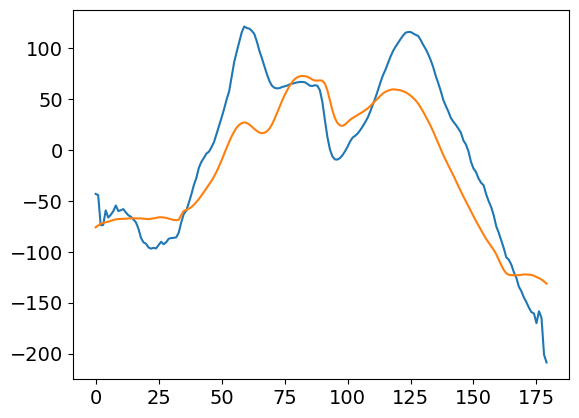

In [24]:
expName = 'CTL'
fname3d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
ds = xr.open_dataset(fname3d)
mse = (Cp*ds.temperature+Lv*ds.qv+G*ds.level)
va = ds.uReconstructMeridional
rhod = (ds.pressure/(Rd*ds.temperature)).mean('lon').mean('time')
dz = np.gradient(ds.level)
coslat = np.cos(np.radians(ds.lat))
del ds

mseFlux_y = (mse*va).mean('time').mean('lon')
mseFlux_y_vint = np.trapz(mseFlux_y*rhod,mse.level,axis=1)
mseFlux_vint_div = np.gradient(mseFlux_y_vint,np.radians(mse.lat)*Rearth,axis=0)

# now we transition to the energy forcing
ncfile = '/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/%s/TC_3km/latlon/radFluxes_r360x180.nc'%expName
ds = xr.open_dataset(ncfile)
E, H, znetclr_atm, znetcf_atm, netsw, netlw, znet_atm = compute_mse_budget(ds)
total = E+H+znet_atm

plt.figure()
plt.plot(mseFlux_vint_div)
plt.plot(total)

Compute eddy term explicitly

In [ ]:
expName = 'CTL'
fname3d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
ds = xr.open_dataset(fname3d)
mse = (Cp*ds.temperature+Lv*ds.qv+G*ds.level)
va = ds.uReconstructMeridional
rhod = (ds.pressure/(Rd*ds.temperature)).mean('lon').mean('time')
dz = np.gradient(ds.level)
coslat = np.cos(np.radians(ds.lat))
del ds

fname3d=pth+expName+'/TC_3km/latlon/climo_diags3d_global_nospinup_r360x180_extended.nc'
ds = xr.open_dataset(fname3d)
mseClimo = (Cp*ds.temperature+Lv*ds.qv+G*ds.level)
vaClimo = ds.uReconstructMeridional
del ds

# subtract the time mean
mse = (mse-mseClimo)
va = (va-vaClimo)

mseFluxEddy_y = (mse*va).mean('time').mean('lon')
mseFluxEddy_y_vint = np.trapz(mseFluxEddy_y*rhod,mse.level,axis=1)
mseFluxEddy_vint_div = np.gradient(mseFluxEddy_y_vint,np.radians(mse.lat)*Rearth,axis=0)

plt.figure()
plt.plot(mseFlux_vint_div)
plt.plot(total)
plt.plot(mseFluxEddy_vint_div)

In [ ]:
plt.figure()
plt.plot(mseFlux_vint_div)
plt.plot(total)
plt.axhline(y=0)

In [ ]:
plt.figure()
for expName in ['minus4K','CTL','plus4K']:
    fname3d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
    ds = xr.open_dataset(fname3d)
    mse = (Cp*ds.temperature+Lv*ds.qv+G*ds.level)
    va = ds.uReconstructMeridional
    rhod = (ds.pressure/(Rd*ds.temperature)).mean('lon').mean('time')
    dz = np.gradient(ds.level)
    coslat = np.cos(np.radians(ds.lat))
    del ds

    mseFlux_vint = np.trapz((mse*va).mean('lon')*rhod,mse.level,axis=-1)
    plt.plot(mse.lat,coslat*mseFlux_vint.mean(axis=0))
    print(np.degrees(mseFlux_vint.mean(axis=0)[90]))
plt.axhline(y=0,color='gray')
plt.axvline(x=0,color='gray')

In [ ]:
# plt.plot(mse.lat,coslat*mseFlux_vint.mean(axis=0))
# plt.axhline(y=0,color='gray')
# plt.axvline(x=-4.2,color='gray')
print(np.degrees(np.radians(76825090.0)/(Rearth*71)))
print(np.degrees(np.radians(703208100.0)/(Rearth*68)))
print(np.degrees(np.radians(1733232100.0)/(Rearth*67)))

### Testing water vapor budget

minus4K


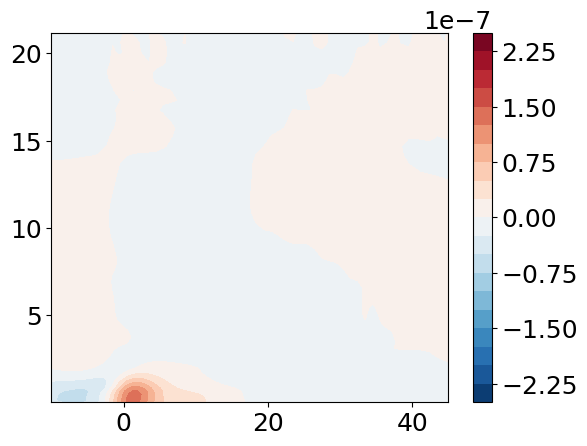

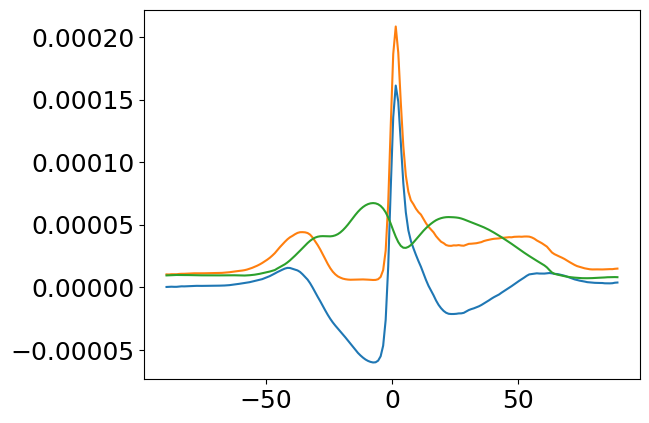

CTL


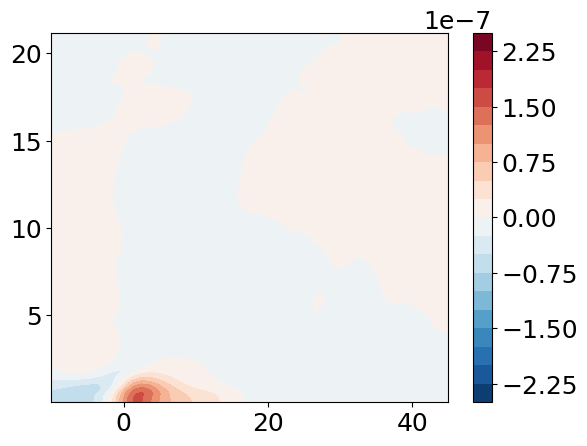

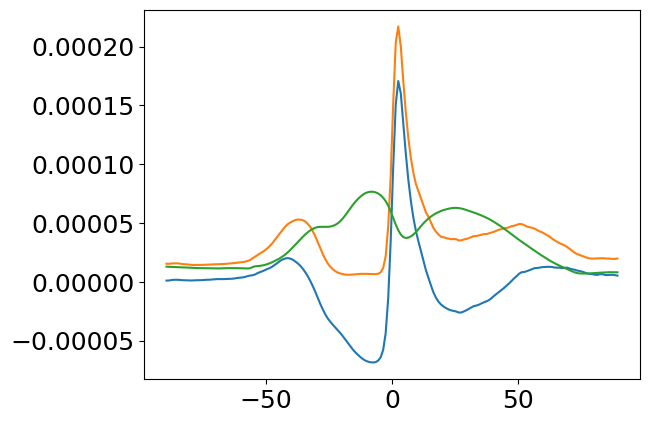

plus4K


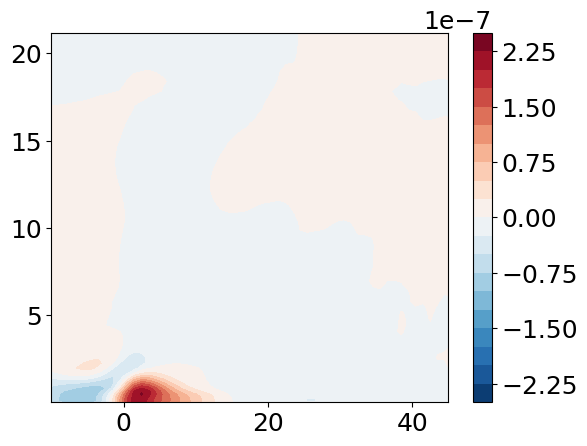

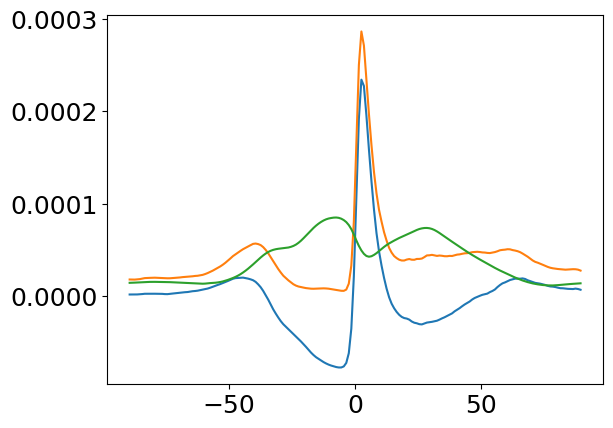

<Figure size 640x480 with 0 Axes>

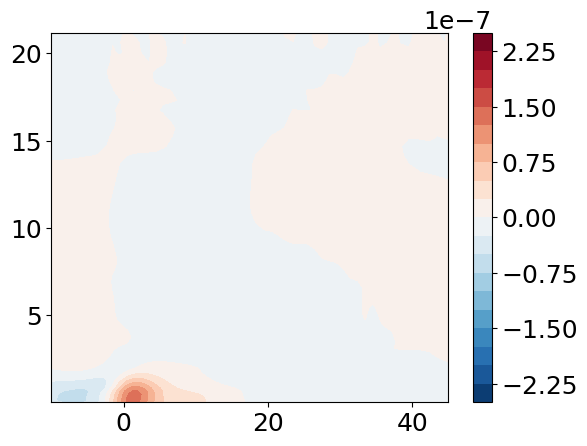

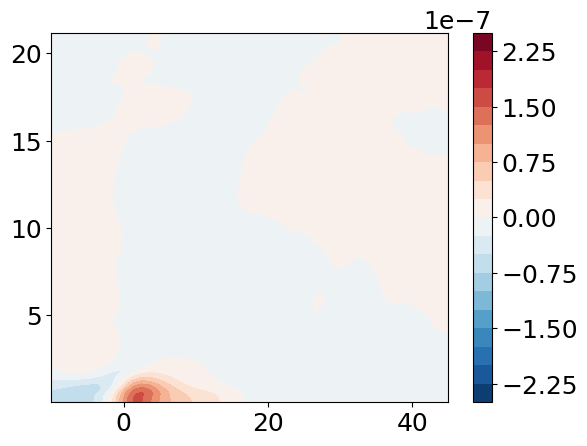

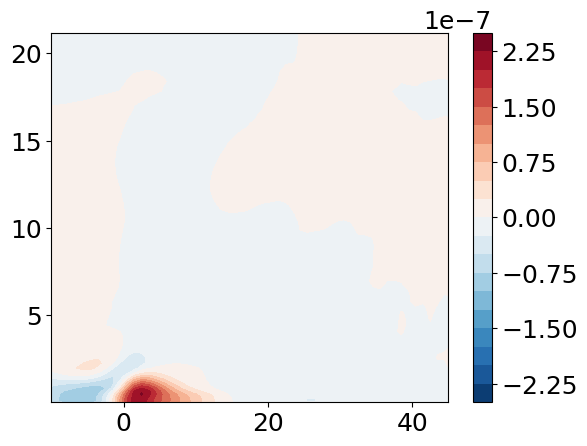

In [31]:
plt.figure()
for expName in ['minus4K','CTL','plus4K']:
    print(expName)
    fname3d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
    ds = xr.open_dataset(fname3d)
    qv = ds.qv
    va = ds.uReconstructMeridional
    rhod = (ds.pressure/(Rd*ds.temperature)).mean('lon').mean('time')
    dz = np.gradient(ds.level)
    coslat = np.cos(np.radians(ds.lat))
    del ds

    # meridional divergence of water vapor flux
    qvFlux = (qv*va).mean('time').mean('lon')
    qvFlux_div = -np.gradient(qvFlux,np.radians(qvFlux.lat)*Rearth,axis=0)
    # vertical integration
    qvFlux_div_vint = np.trapz(qvFlux_div*rhod,qvFlux.level,axis=-1)

    fig=plt.figure()
    [X, Y] = np.meshgrid(qv.lat, qv.level*0.001)
    plt.contourf(X, Y, qvFlux_div.T, cmap='RdBu_r', levels=np.linspace(-2.5e-7,2.5e-7,21))
    plt.colorbar()
    plt.xlim([-10,45])
    display(fig)

    # surface precipitation in kg/m2/s
    fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
    ds = xr.open_dataset(fname2d)
    pr = ds.pr.mean('time').mean('lon')/3600.0
    del ds

    # surface evaporation
    fname2d=pth+expName+'/TC_3km/latlon/radFluxes_r360x180.nc'
    ds = xr.open_dataset(fname2d)
    E = ds.qfx.mean('time').mean('lon')
    del ds

    # plot
    fig=plt.figure()
    plt.plot(E.lat,qvFlux_div_vint)
    plt.plot(E.lat,pr)
    plt.plot(E.lat,E)
    display(fig)
    plt.close()

(-10.0, 45.0)

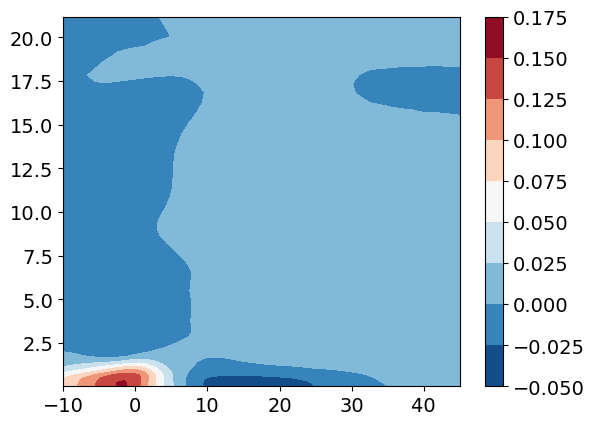

In [49]:
plt.figure()
[X, Y] = np.meshgrid(qv.lat, qv.level*0.001)
plt.contourf(X, Y, qvFlux.T, cmap='RdBu_r') #, levels=np.linspace(-2.5e-7,2.5e-7,21))
plt.colorbar()
plt.xlim([-10,45])

minus4K


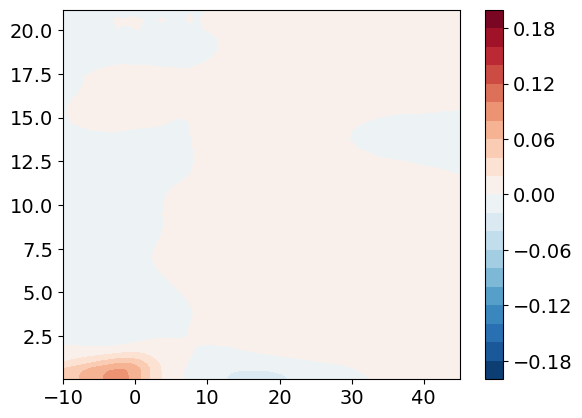

CTL


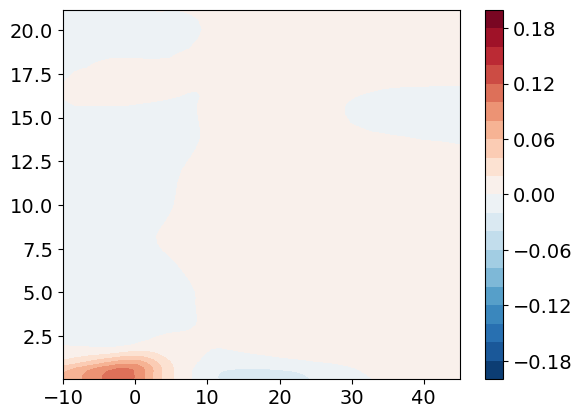

plus4K


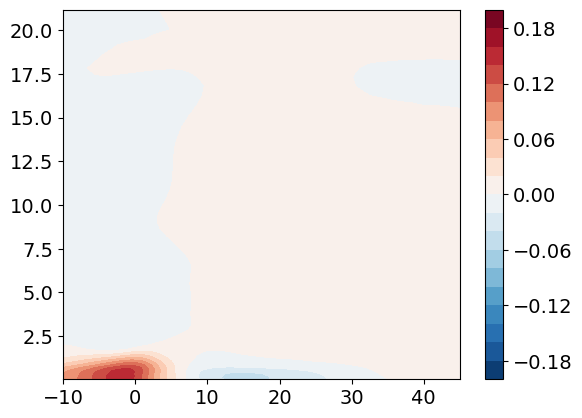

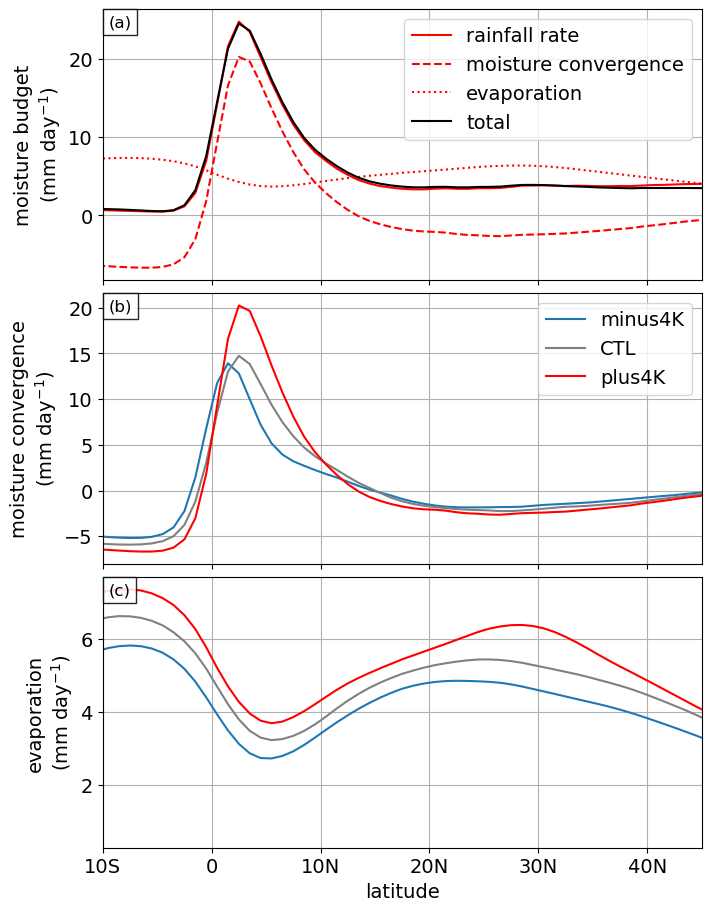

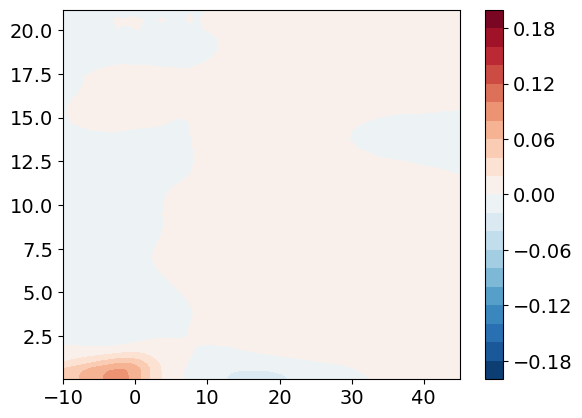

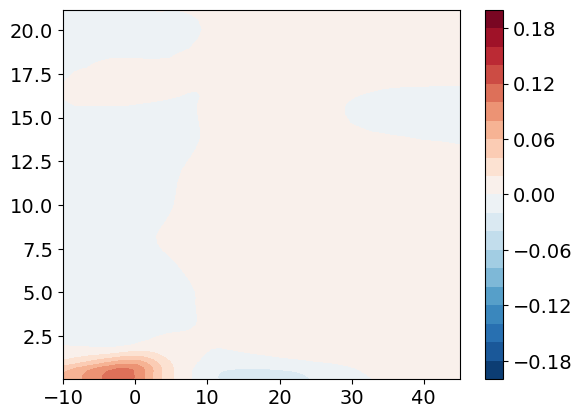

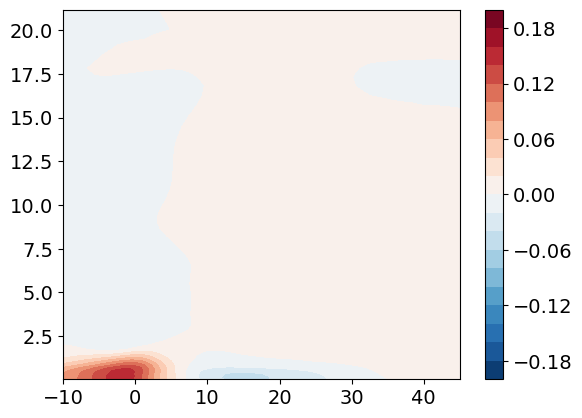

In [50]:
fig, ax = plt.subplots(figsize=(7,3*3),nrows=3,sharex=True,constrained_layout=True)

for expName in ['minus4K','CTL','plus4K']:
    print(expName)

    fname3d=pth+expName+'/TC_3km/latlon/diags3d_global_nospinup_r360x180_extended.nc'
    ds = xr.open_dataset(fname3d)
    qv = ds.qv
    va = ds.uReconstructMeridional
    rhod = (ds.pressure/(Rd*ds.temperature)).mean('lon').mean('time')
    dz = np.gradient(ds.level)
    coslat = np.cos(np.radians(ds.lat))
    del ds

    # meridional divergence of water vapor flux
    qvFlux = (qv*va).mean('time').mean('lon')

    fig=plt.figure()
    [X, Y] = np.meshgrid(qv.lat, qv.level*0.001)
    plt.contourf(X, Y, qvFlux.T, cmap='RdBu_r',levels=np.linspace(-0.2,0.2,21))
    plt.colorbar()
    plt.xlim([-10,45])
    display(fig)
    
    qvFlux_div = -np.gradient(qvFlux,np.radians(qvFlux.lat)*Rearth,axis=0)
    # vertical integration
    qvFlux_div_vint = np.trapz(qvFlux_div*rhod,qvFlux.level,axis=-1)*86400.0
    
    # surface precipitation in kg/m2/s
    fname2d=pth+expName+'/TC_3km/latlon/diags_global_nospinup_r360x180.nc'
    ds = xr.open_dataset(fname2d)
    pr = ds.pr.mean('time').mean('lon')*24. #mm/day
    del ds

    # surface evaporation
    fname2d=pth+expName+'/TC_3km/latlon/radFluxes_r360x180.nc'
    ds = xr.open_dataset(fname2d)
    E = ds.qfx.mean('time').mean('lon')*86400.0
    del ds

    # plot
    ax[1].plot(E.lat, qvFlux_div_vint, color=lineColors[expName])
    ax[2].plot(E.lat, E, color=lineColors[expName])


# for the first panel, we plot the entire water vapor budget from one of the experiments
ax[0].plot(E.lat, pr, color=lineColors[expName])
ax[0].plot(E.lat, qvFlux_div_vint, color=lineColors[expName], linestyle='dashed')
ax[0].plot(E.lat, E, color=lineColors[expName], linestyle='dotted')
ax[0].plot(E.lat, qvFlux_div_vint+E, color='k')
ax[0].legend(['rainfall rate','moisture convergence','evaporation','total'])
ax[0].set_ylabel('moisture budget\n(mm day$^{-1}$)')

# specify y-tick marks
ax[0].grid(True)
ax[1].grid(True)
ax[-1].grid(True)
ax[-1].set_xticks([-10,0,10,20,30,40])
ax[-1].set_xticklabels(['10S','0','10N','20N','30N','40N'])
ax[-1].set_xlim([-10,45])
ax[-1].set_xlabel('latitude')
ax[1].set_ylabel('moisture convergence\n(mm day$^{-1}$)')
ax[-1].set_ylabel('evaporation\n(mm day$^{-1}$)')
# add legend
ax[1].legend(list_of_exps)

#add panel labels
for i,axis in enumerate(ax.flat):
    label = "("+chr(i+97)+")"
    axis.text(0.01, 0.98, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85))
plt.savefig('./Figures/lat_moisture_budget_ASD.jpeg',bbox_inches='tight',dpi=600)

Narrower and stronger ITCZ: consistent with stronger water vapor flux convergence within the ITCZ but stronger water vapor flux divergence at the edges of the ITCZ. Despite stronger evaporation, the ITCZ narrows and weakens consistent with the water vapor flux convergence/divergence. This is consistent with the changes in the Hadley cell...

### Checking time tendencies to make sure they're small

In [ ]:
mse_vint_dt = np.gradient(mse_vint,21600.0,axis=0).mean(axis=0)
plt.plot(total.lat,mse_vint_dt*coslat)
plt.plot(total.lat,total*coslat)
plt.plot(total.lat,mseFlux_vint_div*coslat)

In [ ]:
mse_vint.shape

In [ ]:
mseFlux.T.plot()

In [ ]:
mseFlux.sum('level').sel(lat=0,method='nearest')

In [ ]:
mseFlux_vint.sel(lat=0,method='nearest')

### Test with qobs

In [ ]:
# read in model fields
fname3d='/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_qobs/TC_3km/latlon/diags3d_global_nospinup_r1440x720.nc'
ds = xr.open_dataset(fname3d).sel(time=slice('2000-05-01', '2000-05-31'))
mse = (Cp*ds.t_isobaric+Lv*ds.qv_isobaric+G*ds.z_isobaric)
va = ds.umeridional_isobaric
mse_flux = (mse*va).sum('lon')*Rearth*np.cos(np.radians(ds.lat))*np.radians(ds.lat[-1]-ds.lat[-2])
dp = np.gradient(ds.plev)

fig=plt.figure()
[X,Y] = np.meshgrid(ds.lat,ds.plev)
plt.contourf(X,Y,mse_flux.mean('time').T)
plt.colorbar()
display(fig)
plt.close()

# testing with eliminating with the lowest model level
mse_flux_vint = (mse_flux.mean('time')[:,:]*dp[:]).sum('plev')
print(mse_flux_vint.sel(lat=0,method='nearest'))
fig=plt.figure()
plt.plot(mse_flux_vint.lat,mse_flux_vint*1e-15)
plt.axhline(y=0,color='k')
plt.axvline(x=0,color='k')
display(fig)
plt.close()


In [ ]:
test = mse_flux.sel(lat=0,method='nearest').mean('time')
plt.figure()
plt.plot(test,test.plev)
plt.ylim([100000,10000])

In [ ]:
### next up: interpolate to pressure levels, then calculate vertical integral